## Description

This notebook uses heuristic and learned perceptual evaluation metrics to quantify the quality of synthetic image datasets for deepfake detector training.

We are most interested in measuring
1. realism (how indistinguishable a synthetic image is from a genuine image)
2. intra-dataset image diversity (degree of variation in image subject, style, color, texture, complexity, etc.) 

## Set-up environment

First, follow the set up instructions in the subnet repo Readme (make sure you have finished running 'python download_data.py')

We are also using Learned Perceptual Image Patch Similarity (LPIPS) metric, which can be installed with:

pip install lpips

https://github.com/richzhang/PerceptualSimilarity

In [18]:
%%time

# Standard libraries
import os
import random
import time
import logging
from typing import List, Dict, Tuple, Any
import json

# Third-party libraries
import numpy as np
import PIL
import torch
import lpips
import matplotlib.pyplot as plt


# Bitmind-specific libraries
from bitmind.image_dataset import ImageDataset
from bitmind.constants import DATASET_META

CPU times: user 21 μs, sys: 7 μs, total: 28 μs
Wall time: 29.6 μs


### Configs


In [3]:
%%time
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

CPU times: user 25.2 ms, sys: 30.9 ms, total: 56.1 ms
Wall time: 440 ms


In [4]:
loss_fn_alex = lpips.LPIPS(net='alex').cuda() # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /root/miniconda3/envs/bitmind/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


# Sample real image pair from real dataset

### Load Real Image Datasets

In [4]:
%%time
print("Loading real datasets")
real_image_datasets = [
    ImageDataset(ds['path'], 'test', ds.get('name', None), ds['create_splits'])
    for ds in DATASET_META['real']
]
real_image_datasets

Loading real datasets
CPU times: user 4.44 s, sys: 7.59 s, total: 12 s
Wall time: 22.9 s


In [5]:
for dataset in real_image_datasets:
    print(dataset.huggingface_dataset_path, dataset.dataset)

dalle-mini/open-images Dataset({
    features: ['url', 'key', 'shard_id', 'status', 'error_message', 'width', 'height', 'exif', 'original_width', 'original_height'],
    num_rows: 125436
})
merkol/ffhq-256 Dataset({
    features: ['image'],
    num_rows: 7000
})
saitsharipov/CelebA-HQ Dataset({
    features: ['image'],
    num_rows: 20260
})


In [31]:
img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.ones(1,3,64,64)
d = loss_fn_alex(img0, img1)
d

tensor([[[[0.5780]]]], grad_fn=<AddBackward0>)

In [4]:
def normalize_image(image : PIL.Image.Image):
    """
    Normalize a PIL Image to the range [-1, 1].
    
    Parameters:
    image (PIL.Image.Image): The input image.
    
    Returns:
    np.ndarray: The normalized image as a NumPy array.
    """
    # Convert image to NumPy array
    image_array = np.array(image).astype(np.float32)
    
    # Normalize to [0, 1]
    image_array /= 255.0
    
    # Normalize to [-1, 1]
    normalized_array = (image_array * 2.0) - 1.0
    return normalized_array

def convert_to_tensor(image : PIL.Image.Image):
    """
    Convert a normalized RGB image to a PyTorch tensor with shape (1, 3, w, h).
    
    Parameters:
    image (PIL.Image.Image): The input PIL image.
    
    Returns:
    torch.Tensor: The image as a PyTorch tensor with shape (1, 3, 612, 612).
    """
    # Normalize the image to [-1, 1]
    normalized_image = normalize_image(image)
    
    tensor = torch.tensor(normalized_image)
    tensor = tensor.permute(2, 0, 1)
    tensor = tensor.unsqueeze(0)
    
    return tensor

def preprocess_image_pair(image1 : PIL.Image.Image, image2 : PIL.Image.Image):
    """
    Preprocess a PIL image for LPIP evaluation by resizing to
    the smallest image dimensions and converting to tensor.
    
    Parameters:
    image (PIL.Image.Image): The input PIL image.
    
    Returns:
    torch.Tensor: The image as a PyTorch tensor with shape (1, 3, 612, 612).
    """
    width1, height1 = image1.size
    width2, height2 = image2.size
    
    # Determine the dimensions of the smallest image
    new_width = min(width1, width2)
    new_height = min(height1, height2)
    
    # Resize both images to the smallest dimensions while maintaining aspect ratio
    image1_resized = image1.resize((new_width, new_height), PIL.Image.LANCZOS)
    image2_resized = image2.resize((new_width, new_height), PIL.Image.LANCZOS)
    return convert_to_tensor(image1_resized), convert_to_tensor(image2_resized)

In [43]:
a, b = preprocess_image_pair(real_image_datasets[0][1]['image'], real_image_datasets[0][2]['image'])
print(a.shape, b.shape)
d = loss_fn_alex(a, b)
d

torch.Size([1, 3, 600, 612]) torch.Size([1, 3, 600, 612])


tensor([[[[0.7928]]]], grad_fn=<AddBackward0>)

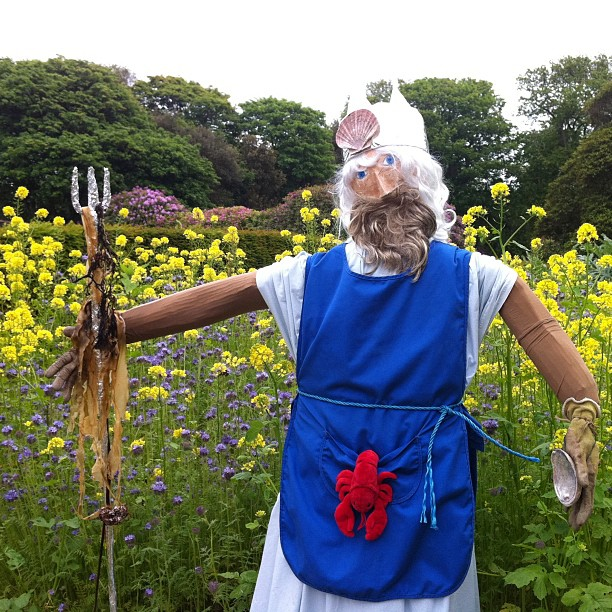

In [46]:
real_image_datasets[0][1]['image']

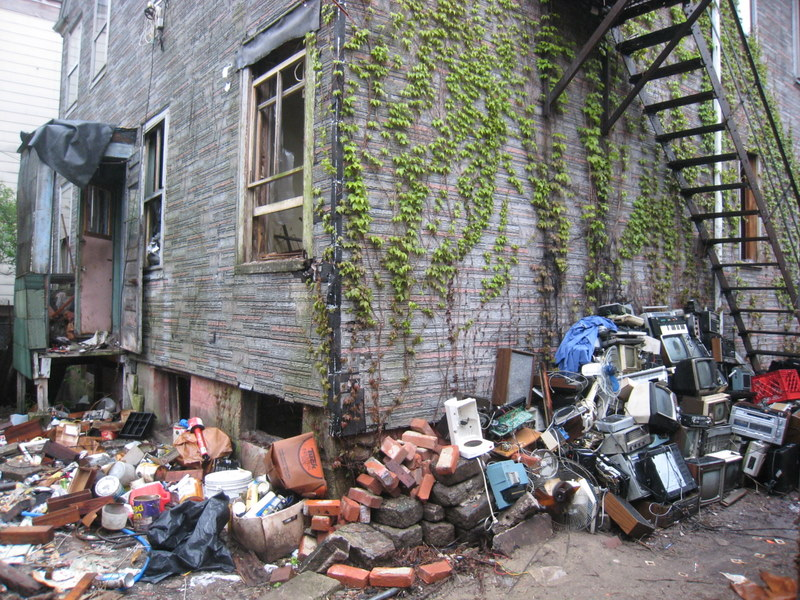

In [47]:
real_image_datasets[0][2]['image']

# Generated synthetic image directory

In [34]:
# utils
def load_image(path):
    if(path[-3:] == 'dng'):
        import rawpy
        with rawpy.imread(path) as raw:
            img = raw.postprocess()
    elif(path[-3:]=='bmp' or path[-3:]=='jpg' or path[-3:]=='png' or path[-4:]=='jpeg'):
        import cv2
        return cv2.imread(path)[:,:,::-1]
    else:
        img = (255*plt.imread(path)[:,:,:3]).astype('uint8')

    return img

def im2tensor(image, imtype=np.uint8, cent=1., factor=255./2.):
    return torch.Tensor((image / factor - cent)
                        [:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def isImageFile(filepath):
    return filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))

In [49]:
def compute_image_directory_lpip(directory, output_file, max_images=None, use_gpu=False, all_pairs=False):
    """
    Calculate and write the perceptual distance metric between images in a specified directory using LPIPS.

    Args:
        directory (str): Path to the directory containing images to compare.
        output_file (str): File path where the LPIP distance will be written.
        max_images (int, optional): Maximum number of images to process. If None, processes all images.
        use_gpu (bool, optional): If True, utilizes GPU to accelerate the computation.
        all_pairs (bool, optional): If True, computes distances for all pairs of images. If False, computes only for sequential pairs.

    Returns:
        None: This function writes the results directly to the output file and does not return any value.
    """
    # Initialize the LPIPS model with a predefined neural network (e.g., AlexNet).
    loss_fn = lpips.LPIPS(net='alex')  # Example using AlexNet

    # Open the output file for writing results
    with open(directory+output_file, 'w') as f:
        files = sorted(os.listdir(directory))
        if max_images is not None:
            files = files[:max_images]

        dists = []  # List to hold computed distances

        # Process each file in the directory
        for i, file in enumerate(files[:-1]):
            if not isImageFile(os.path.join(directory, file)): continue
            img0 = lpips.im2tensor(load_image(os.path.join(directory, file)))#lpips.load_image(os.path.join(directory, file)))  # Convert image to tensor
            if use_gpu:
                img0 = img0.cuda()  # Transfer tensor to GPU if enabled

            # Determine comparison targets based on 'all_pairs' flag
            if all_pairs:
                files1 = files[i+1:]
            else:
                files1 = [files[i+1]] if i + 1 < len(files) else []

            for file1 in files1:
                if not isImageFile(os.path.join(directory, file1)): continue
                img1 = lpips.im2tensor(load_image(os.path.join(directory, file1)))
                if use_gpu:
                    img1 = img1.cuda()

                # Compute the perceptual metric between two images
                dist01 = loss_fn.forward(img0, img1)
                print('({}, {}): {:.3f}'.format(file, file1, dist01))
                f.write('({}, {}): {:.6f}\n'.format(file, file1, dist01.item()))

                dists.append(dist01.item())

        # Calculate statistics: average distance and standard error
        try:
            avg_dist = np.mean(dists)
            stderr_dist = np.std(dists) / np.sqrt(len(dists))
            print('Avg: {:.5f} +/- {:.5f}'.format(avg_dist, stderr_dist))
            f.write('Avg: {:.6f} +/- {:.6f}'.format(avg_dist, stderr_dist))
        except Exception as e: print('Error:', e)

In [48]:
img_dir = 'synthetics_from_annotations/dalle-mini_open-images/RealVisXL_V4.0/'
compute_image_directory_lpip(img_dir, 'lpip_metrics', max_images=None, use_gpu=True, all_pairs=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /root/miniconda3/envs/bitmind/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Avg: nan +/- nan
